# MDI+: Example Usages

In [72]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append("../")
sys.path.append("../../")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_absolute_error, accuracy_score, roc_auc_score, mean_squared_error

from imodels.importance import RandomForestPlusRegressor, RandomForestPlusClassifier, \
    RidgeRegressorPPM, LassoRegressorPPM, IdentityTransformer
from imodels.importance.rf_plus import _fast_r2_score

In [73]:
# helper variables
rf_regressor = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, max_features=0.33, random_state=331)
rf_classifier = RandomForestClassifier(n_estimators=100, min_samples_leaf=1, max_features="sqrt", random_state=331)

## 1. Regression Example

In [74]:
# generate data from linear model: y = x1 + x2 + N(0, 1)
n = 200
p = 10
s = 2
X = np.random.normal(size=(n, p))
# center and scale X
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
beta = np.concatenate((np.ones(s), np.zeros(p-s)))
y = np.matmul(X, beta) + np.random.normal(size=n)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=12345)
# center and scale X_train and X_test
X_train = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
X_test = (X_test - np.mean(X_test, axis=0)) / np.std(X_test, axis=0)

### 1.1 Local MDI+ (Feature Contribution) w/ Regression

In [75]:
# fit RF+
rf_plus_model = RandomForestPlusRegressor(rf_model=rf_regressor, include_raw=False)
rf_plus_model.fit(X_train, y_train)

In [76]:
# make predictions with RF+
preds = rf_plus_model.predict(X_test)
r2_score(y_test, preds)

0.4062242519243294

#### Leave-One-Out Coefficients: $LFI(i,k)=\sum_{j=1}^p|\hat{\beta}^{(k)}_{-i,j}*\Psi^{(k)}_{i,j}|$

In [77]:
# get MDI+ scores (higher r^2 value = greater importance)
mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X_train, y_train, lfi=True,
                                                    lfi_type = "loo",
                                                    lfi_abs = "inside")

Local MDI+ w/ Leave-One-Out Coefficients and Inner Absolute Value
------------------------------------
            0         1         2         3         4         5         6  \
0    0.637972  0.492479  0.186251  0.118834  0.143479  0.274801  0.187658   
1    0.569655  0.589124  0.244449  0.140484  0.159270  0.333997  0.195974   
2    0.656108  0.567631  0.190265  0.134549  0.100843  0.230270  0.228222   
3    0.626345  0.519347  0.210327  0.155887  0.167843  0.324368  0.252551   
4    0.562087  0.618671  0.182885  0.098324  0.118735  0.300752  0.268810   
..        ...       ...       ...       ...       ...       ...       ...   
129  0.633171  0.516095  0.182614  0.106467  0.175186  0.489906  0.159190   
130  0.579589  0.485479  0.189770  0.118444  0.133042  0.255335  0.183070   
131  0.749958  0.604108  0.235386  0.179608  0.144333  0.314884  0.145583   
132  0.771666  0.562845  0.146900  0.138917  0.231320  0.298692  0.195110   
133  0.596189  0.588512  0.231832  0.149401  0.180

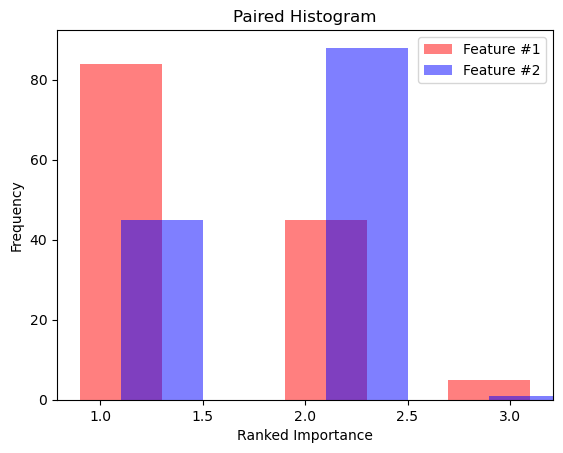

In [78]:
print("Local MDI+ w/ Leave-One-Out Coefficients and Inner Absolute Value")
print("------------------------------------")
lfi_loo_inner = mdi_plus_scores["lfi"]
print(lfi_loo_inner)
print("------------------------------------")
print("Recall that the first two columns are the only ones with signal.")
print("Histogram of Rank of First Column (Red) and Second Column (Blue)")
lfi_rank = lfi_loo_inner.rank(axis=1, method="dense", ascending=False)
fig, ax = plt.subplots()
ax.hist(lfi_rank.iloc[:, 0], alpha = 0.5, label='Feature #1', align = "left",
        width = 0.4, color = "red")
ax.hist(lfi_rank.iloc[:, 1], alpha = 0.5, label='Feature #2', align = "right",
        width = 0.4, color = "blue")
ax.set_xlabel('Ranked Importance')
ax.set_ylabel('Frequency')
ax.set_title('Paired Histogram')
ax.legend()
plt.show()

#### Leave-One-Out Coefficients: $LFI(i,k)=|\sum_{j=1}^p\hat{\beta}^{(k)}_{-i,j}*\Psi^{(k)}_{i,j}|$

In [79]:
# get MDI+ scores (higher r^2 value = greater importance)
mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X_train, y_train, lfi=True,
                                                    lfi_type = "loo",
                                                    lfi_abs = "outside")

Local MDI+ w/ Leave-One-Out Coefficients and Outer Absolute Value
------------------------------------
            0         1         2         3         4         5         6  \
0    0.616112  0.299508  0.177593  0.108872  0.133564  0.240857  0.175985   
1    0.391112  0.456954  0.239989  0.136747  0.151902  0.312355  0.192733   
2    0.636536  0.546761  0.180693  0.124205  0.094997  0.208397  0.224987   
3    0.599938  0.328592  0.186024  0.151916  0.134940  0.316758  0.240974   
4    0.389405  0.485235  0.155409  0.087774  0.105532  0.285197  0.250198   
..        ...       ...       ...       ...       ...       ...       ...   
129  0.613213  0.356265  0.152614  0.096233  0.156704  0.483405  0.145329   
130  0.402080  0.390625  0.152187  0.109491  0.123543  0.235522  0.166977   
131  0.723903  0.525053  0.232702  0.176279  0.138696  0.294699  0.135341   
132  0.749632  0.487853  0.117409  0.135594  0.222144  0.233734  0.179300   
133  0.566477  0.412309  0.223296  0.138844  0.175

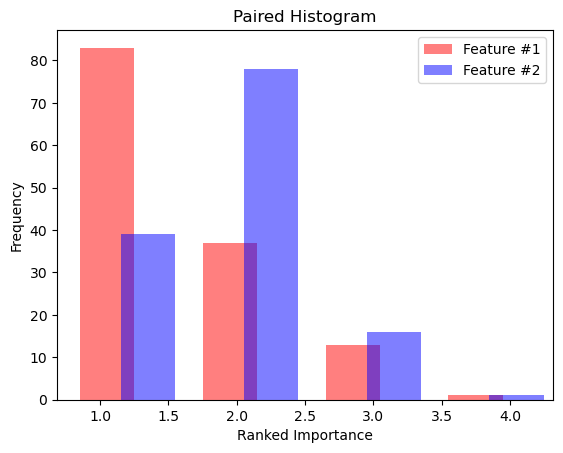

In [80]:
print("Local MDI+ w/ Leave-One-Out Coefficients and Outer Absolute Value")
print("------------------------------------")
lfi_loo_outer = mdi_plus_scores["lfi"]
print(lfi_loo_outer)
print("------------------------------------")
print("Recall that the first two columns are the only ones with signal.")
print("Histogram of Rank of First Column (Red) and Second Column (Blue)")
lfi_rank = lfi_loo_outer.rank(axis=1, method="dense", ascending=False)
fig, ax = plt.subplots()
ax.hist(lfi_rank.iloc[:, 0], alpha = 0.5, label='Feature #1', align = "left",
        width = 0.4, color = "red")
ax.hist(lfi_rank.iloc[:, 1], alpha = 0.5, label='Feature #2', align = "right",
        width = 0.4, color = "blue")
ax.set_xlabel('Ranked Importance')
ax.set_ylabel('Frequency')
ax.set_title('Paired Histogram')
ax.legend()
plt.show()

#### Standard Coefficients: $LFI(i,k)=\sum_{j=1}^p|\hat{\beta}^{(k)}_{j}*\Psi^{(k)}_{i,j}|$

In [81]:
# get MDI+ scores (higher r^2 value = greater importance)
mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X_train, y_train, lfi=True,
                                                    lfi_type = "standard",
                                                    lfi_abs = "inside")

Local MDI+ w/ Standard Coefficients and Inner Absolute Value
------------------------------------
            0         1         2         3         4         5         6  \
0    0.634560  0.491027  0.185918  0.118902  0.142847  0.274760  0.187455   
1    0.567406  0.588558  0.242781  0.140291  0.159012  0.333783  0.195829   
2    0.696389  0.579330  0.195535  0.136609  0.103040  0.236361  0.229881   
3    0.630660  0.520423  0.210981  0.156456  0.168364  0.325111  0.253446   
4    0.559340  0.617863  0.182537  0.098055  0.118598  0.300922  0.266731   
..        ...       ...       ...       ...       ...       ...       ...   
129  0.636665  0.517434  0.183469  0.107025  0.175644  0.488803  0.159805   
130  0.578257  0.484883  0.189875  0.117987  0.132992  0.256362  0.183115   
131  0.771171  0.612205  0.240169  0.181378  0.146848  0.318618  0.147741   
132  0.793029  0.570626  0.148600  0.141196  0.232981  0.302653  0.199030   
133  0.606240  0.592586  0.233048  0.150252  0.181650  

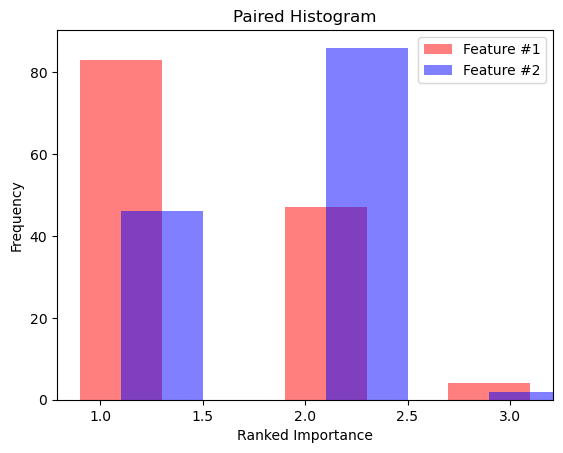

In [82]:
print("Local MDI+ w/ Standard Coefficients and Inner Absolute Value")
print("------------------------------------")
lfi_standard_inside = mdi_plus_scores["lfi"]
print(lfi_standard_inside)
print("------------------------------------")
print("Recall that the first two columns are the only ones with signal.")
print("Histogram of Rank of First Column (Red) and Second Column (Blue)")
lfi_rank = lfi_standard_inside.rank(axis=1, method="dense", ascending=False)
fig, ax = plt.subplots()
ax.hist(lfi_rank.iloc[:, 0], alpha = 0.5, label='Feature #1', align = "left",
        width = 0.4, color = "red")
ax.hist(lfi_rank.iloc[:, 1], alpha = 0.5, label='Feature #2', align = "right",
        width = 0.4, color = "blue")
ax.set_xlabel('Ranked Importance')
ax.set_ylabel('Frequency')
ax.set_title('Paired Histogram')
ax.legend()
plt.show()

#### Standard Coefficients: $LFI(i,k)=|\sum_{j=1}^p\hat{\beta}^{(k)}_{j}*\Psi^{(k)}_{i,j}|$

In [83]:
# get MDI+ scores (higher r^2 value = greater importance)
mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X_train, y_train, lfi=True,
                                                    lfi_type = "standard",
                                                    lfi_abs = "outside")

Local MDI+ w/ Standard Coefficients and Outer Absolute Value
------------------------------------
            0         1         2         3         4         5         6  \
0    0.612627  0.298410  0.177261  0.108975  0.132868  0.240837  0.175839   
1    0.384274  0.455690  0.238327  0.136540  0.151672  0.312189  0.192561   
2    0.676819  0.557922  0.185879  0.125933  0.097052  0.214245  0.226579   
3    0.604986  0.329774  0.186471  0.152462  0.135429  0.317417  0.241830   
4    0.387810  0.485076  0.154675  0.087504  0.105399  0.285290  0.248131   
..        ...       ...       ...       ...       ...       ...       ...   
129  0.617827  0.357620  0.153163  0.096771  0.157184  0.482291  0.145750   
130  0.403524  0.390225  0.152269  0.109033  0.123495  0.236714  0.167024   
131  0.745128  0.532326  0.237379  0.178029  0.141159  0.298175  0.137437   
132  0.770996  0.494551  0.119246  0.137870  0.223791  0.237344  0.183144   
133  0.576696  0.415422  0.224569  0.139646  0.176213  

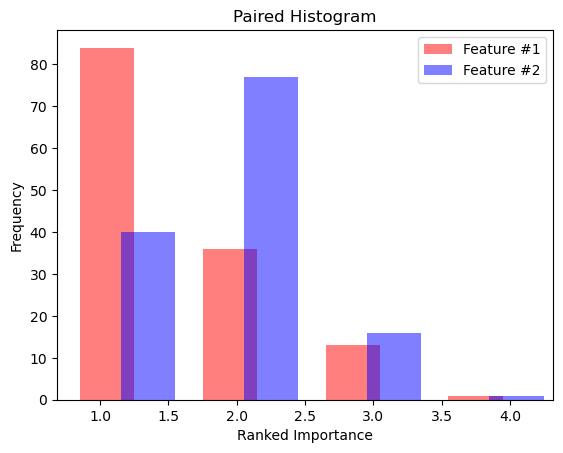

In [84]:
print("Local MDI+ w/ Standard Coefficients and Outer Absolute Value")
print("------------------------------------")
lfi_standard_inside = mdi_plus_scores["lfi"]
print(lfi_standard_inside)
print("------------------------------------")
print("Recall that the first two columns are the only ones with signal.")
print("Histogram of Rank of First Column (Red) and Second Column (Blue)")
lfi_rank = lfi_standard_inside.rank(axis=1, method="dense", ascending=False)
fig, ax = plt.subplots()
ax.hist(lfi_rank.iloc[:, 0], alpha = 0.5, label='Feature #1', align = "left",
        width = 0.4, color = "red")
ax.hist(lfi_rank.iloc[:, 1], alpha = 0.5, label='Feature #2', align = "right",
        width = 0.4, color = "blue")
ax.set_xlabel('Ranked Importance')
ax.set_ylabel('Frequency')
ax.set_title('Paired Histogram')
ax.legend()
plt.show()